In [115]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import alpaca_trade_api as tradeapi
import datetime as dt
import pytz

class MCSimulation:
    """
    A Python class for runnning Monte Carlo simulation on portfolio price data. 
    
    ...
    
    Attributes
    ----------
    portfolio_data : pandas.DataFrame
        portfolio dataframe
    weights: list(float)
        portfolio investment breakdown
    nSim: int
        number of samples in simulation
    nTrading: int
        number of trading days to simulate
    simulated_return : pandas.DataFrame
        Simulated data from Monte Carlo
    confidence_interval : pandas.Series
        the 95% confidence intervals for simulated final cumulative returns
        
    """
    
    def __init__(self, portfolio_data, weights="", num_simulation=1000, num_trading_days=252):
        """
        Constructs all the necessary attributes for the MCSimulation object.

        Parameters
        ----------
        portfolio_data: pandas.DataFrame
            DataFrame containing stock price information from Alpaca API
        weights: list(float)
            A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
        num_simulation: int
            Number of simulation samples. DEFAULT: 1000 simulation samples
        num_trading_days: int
            Number of trading days to simulate. DEFAULT: 252 days (1 year of business days)
        """
        
        # Check to make sure that all attributes are set
        if not isinstance(portfolio_data, pd.DataFrame):
            raise TypeError("portfolio_data must be a Pandas DataFrame")
            
        # Set weights if empty, otherwise make sure sum of weights equals one.
        if weights == "":
            num_stocks = len(portfolio_data.columns.get_level_values(0).unique())
            weights = [1.0/num_stocks for s in range(0,num_stocks)]
        else:
            if round(sum(weights),2) < .99:
                raise AttributeError("Sum of portfolio weights must equal one.")
        
        # Calculate daily return if not within dataframe
        if not "daily_return" in portfolio_data.columns.get_level_values(1).unique():
            close_df = portfolio_data.xs('close',level=1,axis=1).pct_change()
            tickers = portfolio_data.columns.get_level_values(0).unique()
            column_names = [(x,"daily_return") for x in tickers]
            close_df.columns = pd.MultiIndex.from_tuples(column_names)
            portfolio_data = portfolio_data.merge(close_df,left_index=True,right_index=True).reindex(columns=tickers,level=0)    
        
        # Set class attributes
        self.portfolio_data = portfolio_data
        self.weights = weights
        self.nSim = num_simulation
        self.nTrading = num_trading_days
        self.simulated_return = ""
        
    def calc_cumulative_return(self):
        """
        Calculates the cumulative return of a stock over time using a Monte Carlo simulation (Brownian motion with drift).

        """
        
        # Get closing prices of each stock
        last_prices = self.portfolio_data.xs('close',level=1,axis=1)[-1:].values.tolist()[0]
        
        # Calculate the mean and standard deviation of daily returns for each stock
        daily_returns = self.portfolio_data.xs('daily_return',level=1,axis=1)
        mean_returns = daily_returns.mean().tolist()
        std_returns = daily_returns.std().tolist()
        
        # Initialize empty Dataframe to hold simulated prices
        portfolio_cumulative_returns = pd.DataFrame()
        
        # Run the simulation of projecting stock prices 'nSim' number of times
        for n in range(self.nSim):
        
            if n % 10 == 0:
                print(f"Running Monte Carlo simulation number {n}.")
        
            # Create a list of lists to contain the simulated values for each stock
            simvals = [[p] for p in last_prices]
    
            # For each stock in our data:
            for s in range(len(last_prices)):

                # Simulate the returns for each trading day
                for i in range(self.nTrading):
        
                    # Calculate the simulated price using the last price within the list
                    simvals[s].append(simvals[s][-1] * (1 + np.random.normal(mean_returns[s], std_returns[s])))
    
            # Calculate the daily returns of simulated prices
            sim_df = pd.DataFrame(simvals).T.pct_change()
    
            # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
            sim_df = sim_df.dot(self.weights)
    
            # Calculate the normalized, cumulative return series
            portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()
        
        # Set attribute to use in plotting
        self.simulated_return = portfolio_cumulative_returns
        
        # Calculate 95% confidence intervals for final cumulative returns
        self.confidence_interval = portfolio_cumulative_returns.iloc[-1, :].quantile(q=[0.025, 0.975])
        
        return portfolio_cumulative_returns
    
    def plot_simulation(self):
        """
        Visualizes the simulated stock trajectories using calc_cumulative_return method.

        """ 
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        # Use Pandas plot function to plot the return data
        plot_title = f"{self.nSim} Simulations of Cumulative Portfolio Return Trajectories Over the Next {self.nTrading} Trading Days."
        return self.simulated_return.plot(legend=None,title=plot_title)
    
    def plot_distribution(self):
        """
        Visualizes the distribution of cumulative returns simulated using calc_cumulative_return method.

        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
        
        # Use the `plot` function to create a probability distribution histogram of simulated ending prices
        # with markings for a 95% confidence interval
        plot_title = f"Distribution of Final Cumuluative Returns Across All {self.nSim} Simulations"
        plt = self.simulated_return.iloc[-1, :].plot(kind='hist', bins=10,density=True,title=plot_title)
        plt.axvline(self.confidence_interval.iloc[0], color='r')
        plt.axvline(self.confidence_interval.iloc[1], color='r')
        return plt
    
    def summarize_cumulative_return(self):
        """
        Calculate final summary statistics for Monte Carlo simulated stock data.
        
        """
        
        # Check to make sure that simulation has run previously. 
        if not isinstance(self.simulated_return,pd.DataFrame):
            self.calc_cumulative_return()
            
        metrics = self.simulated_return.iloc[-1].describe()
        ci_series = self.confidence_interval
        ci_series.index = ["95% CI Lower","95% CI Upper"]
        return metrics.append(ci_series)

In [116]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
# from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [117]:
#Load .env environment variables
load_dotenv()

True

In [118]:



#PART 1 - PERSONAL FINANCE PLANNER




In [119]:
#Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [120]:
 # Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [121]:
#Fetch Current BTC price
#Here we are using requests to pull data from the API's
btc_data = requests.get(btc_url).json()
current_btc = btc_data['data']['1']['quotes']['CAD']['price']
print(current_btc)

57464.2953


In [122]:
#Fetch Current ETH price
eth_data = requests.get(eth_url).json()
current_eth = eth_data['data']['1027']['quotes']['CAD']['price']
print(current_eth)

4368.458034


In [123]:
#Compute current value of my crypto
#Here we are multiplying the number of bitcoins and ethereum by the current value
my_btc_value = (my_btc * current_btc) 
my_eth_value = (my_eth * current_eth)

In [124]:
# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $68957.15
The current value of your 5.3 ETH is $23152.83


In [125]:
#Set current amount of shares
my_agg = 200
my_spy = 50

In [126]:
# Set Alpaca API key and secret
#Here we are pulling the alpaca api and secret key from an env file
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca API object
#Here we are creating the api object using the alpaca trade api 
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)


In [127]:
#Format Current Date as ISO format
#Here we chose a 1 year time frame and set it to ISO format
start_date = pd.Timestamp("2021-04-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-04-01", tz="America/New_York").isoformat()


In [128]:
#Set the tickers
tickers = ['AGG', 'SPY']

In [129]:
#Set timeframe to "1Day" for Alpaca API
timeframe = '1Day'

In [130]:
#Get current closing prices for SPY and AGG
#Here we are creating a new data frame using our api object and calling the variables tickers, timeframe, start, end and limit.
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit = 10000
).df

df_ticker

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2021-04-01 04:00:00+00:00,113.93,114.0500,113.830,114.04,10766423,31622,113.979773,AGG
2021-04-05 04:00:00+00:00,113.84,113.8900,113.690,113.81,9229625,32639,113.804845,AGG
2021-04-06 04:00:00+00:00,113.98,114.2200,113.950,114.21,4859922,19800,114.112076,AGG
2021-04-07 04:00:00+00:00,114.12,114.2584,114.025,114.03,4502694,18636,114.143055,AGG
2021-04-08 04:00:00+00:00,114.18,114.3100,114.130,114.31,4932134,16440,114.244478,AGG
...,...,...,...,...,...,...,...,...
2022-03-28 04:00:00+00:00,452.05,455.9100,450.060,455.84,68744767,624225,453.296491,SPY
2022-03-29 04:00:00+00:00,460.07,462.0700,457.180,461.53,86682895,738526,459.632992,SPY
2022-03-30 04:00:00+00:00,460.29,461.1950,456.465,458.79,79668682,659199,459.158702,SPY


In [131]:
#Reorganize the Data Frame
#Seperate Ticker Data
SPY = df_ticker[df_ticker['symbol']=='SPY'].drop('symbol', axis = 1)
AGG = df_ticker[df_ticker['symbol']=='AGG'].drop('symbol', axis = 1)

In [132]:
#Concatenate the ticker DataFrames
df_ticker = pd.concat([SPY, AGG], axis = 1, keys=['SPY', 'AGG'])

In [133]:
#Preview the Data Frame
df_ticker.head()

SPY                                    \
                             open    high     low   close    volume   
timestamp                                                             
2021-04-01 04:00:00+00:00  398.34  400.67  398.18  400.61  99157757   
2021-04-05 04:00:00+00:00  403.49  406.94  403.38  406.36  91242966   
2021-04-06 04:00:00+00:00  405.83  407.24  405.40  406.12  61766326   
2021-04-07 04:00:00+00:00  405.95  406.96  405.45  406.59  55311029   
2021-04-08 04:00:00+00:00  407.92  408.58  406.93  408.52  57220303   

                                                      AGG                     \
                          trade_count        vwap    open      high      low   
timestamp                                                                      
2021-04-01 04:00:00+00:00      386557  398.274085  113.93  114.0500  113.830   
2021-04-05 04:00:00+00:00      446985  404.939779  113.84  113.8900  113.690   
2021-04-06 04:00:00+00:00      330698  406.378556  113.98  114.2200  113.950   
2021-04-07 04:00:00+00:00      306691  406.321664  114.12  114.2584  114.025   
2021-04-08 04:00:00+00:00      298240  407.775945  114.18  114.3100  114.130   

                                                                     
                            close    volume trade_count        vwap  
timestamp                                                            
2021-04-01 04:00:00+00:00  114.04  10766423       31622  113.979773  
2021-04-05 04:00:00+00:00  113.81   9229625       32639  113.804845  
2021-04-06 04:00:00+00:00  114.21   4859922       19800  114.112076  
2021-04-07 04:00:00+00:00  114.03   4502694       18636  114.143055  
2021-04-08 04:00:00+00:00  114.31   4932134       16440  114.244478

In [134]:
#Pick AGG and SPY close prices
#We are setting the date to the last trading day and pulling the close price
spy_close_price = df_ticker['SPY']['close']['2022-04-01 04:00:00+00:00']
agg_close_price = df_ticker['AGG']['close']['2022-04-01 04:00:00+00:00']

In [135]:
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $106.75
Current SPY closing price: $452.92


In [136]:
#Compute the current value of shares
#Here we multiply amount of SPY shares and AGG shares by their closing price
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

In [137]:
# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22646.00
The current value of your 200 AGG shares is $21350.00


In [138]:


#SAVING HEALTH ANALYSIS



In [139]:
#Set monthly household income
monthly_income = 12000

In [140]:
#Consolidate financial assets data
#Here we are adding btc value and eth value and assigning it to crypto. We are also adding stock share values to the variable shares.
crypto = my_btc_value + my_eth_value
shares = my_spy_value + my_agg_value
#Here we are creating a list that we can use to set the names of the rows in our new data frame.
savings = ['crypto', 'shares']
#And here we are creating a dictionary to pull column name and values from to support our row names.
amount_data = {
    "amount": [crypto, shares]
}

In [141]:
#Create Savings Data Frame
#Here we are combining variable crypto and shares to create a dataframe
df_savings = pd.DataFrame(amount_data , index = savings)
df_savings


,amount
crypto,92109.98194
shares,43996.00000


array([<AxesSubplot:ylabel='amount'>], dtype=object)

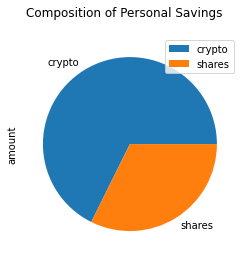

In [142]:
#Plot savings pie chart
df_savings.plot.pie(title = "Composition of Personal Savings" , subplots = True)

In [143]:
#Set ideal emergency fund
#Ideal emergencey fund is monthly income x 3
emergency_fund = monthly_income * 3

In [144]:
#Calculate total amount of savings
total_savings = crypto + shares

In [145]:
#Validate saving health
if total_savings >= emergency_fund:
    print("Congratulations! You have enough money in your emergency fund")
else:
    print("You do not have enough money in your emergencey fund")

Congratulations! You have enough money in your emergency fund


In [146]:



#PART 2 - RETIREMENT PLANNING




In [147]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-04-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-04-01', tz='America/New_York').isoformat()

In [148]:
#Get 5 years worth of historical data for SPY and AGG
#Here we are again creating a data frame but for 5 years of SPY and AGG data.
df_five_year = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit = 10000
).df

In [149]:
#Reorganize the Data Frame
#Seperate Ticker Data
#Reorganize the Data Frame
#Seperate Ticker Data
#Here we are seperating tickers data by dropping the symbols from the data to make it easier to concat and setting the new data frames to variables SPY and AGG
SPY = df_five_year[df_five_year['symbol']=='SPY'].drop('symbol', axis = 1)
AGG = df_five_year[df_five_year['symbol']=='AGG'].drop('symbol', axis = 1)

In [150]:
#Concatenate the ticker DataFrames
#Now we concat the data frames together to create a new data frame with SPY and AGG as keys
df_five_year = pd.concat([SPY, AGG], axis = 1, keys=['SPY', 'AGG'])

In [151]:
#Display sample data
df_five_year.head()

SPY                                       \
                             open      high     low   close     volume   
timestamp                                                                
2016-04-01 04:00:00+00:00  204.35  207.1400  203.98  206.91  114405478   
2016-04-04 04:00:00+00:00  206.84  207.0700  205.89  206.29   63495969   
2016-04-05 04:00:00+00:00  204.64  206.2642  203.89  204.14   99662158   
2016-04-06 04:00:00+00:00  204.27  206.4900  203.98  206.46   91834261   
2016-04-07 04:00:00+00:00  205.18  205.5600  203.09  203.89  113859037   

                                                      AGG                      \
                          trade_count        vwap    open      high       low   
timestamp                                                                       
2016-04-01 04:00:00+00:00      397066  206.036128  110.53  110.6599  110.3500   
2016-04-04 04:00:00+00:00      249269  206.409892  110.60  110.6700  110.5100   
2016-04-05 04:00:00+00:00      351543  204.579339  110.87  110.9750  110.7100   
2016-04-06 04:00:00+00:00      391426  205.374770  110.80  110.8000  110.6235   
2016-04-07 04:00:00+00:00      411645  204.378824  110.98  111.0500  110.7700   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2016-04-01 04:00:00+00:00  110.51  5374230       15909  110.508405  
2016-04-04 04:00:00+00:00  110.62  3176154        9671  110.566831  
2016-04-05 04:00:00+00:00  110.77  2954123       11700  110.807661  
2016-04-06 04:00:00+00:00  110.75  2027437       10157  110.707187  
2016-04-07 04:00:00+00:00  110.99  1876140        8054  110.986625

In [152]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
#Here we are creating a variable to represent our number of simulations
num_sims = 500
#Here we use the MCSsimultion function to create us a MCS object which we can use to do our montecarlo simulation
MC_SPY_AGG = MCSimulation(
    portfolio_data = df_five_year,
    num_simulation = num_sims,
    num_trading_days = 252 * 30, #Here we are multiplying trading days in a year by number of years
    weights = [.40,.60] #Here we are setting the 40/60 split between bonds and stocks
)


In [153]:
#Printing the simulation input data
df_five_year.head()

SPY                                       \
                             open      high     low   close     volume   
timestamp                                                                
2016-04-01 04:00:00+00:00  204.35  207.1400  203.98  206.91  114405478   
2016-04-04 04:00:00+00:00  206.84  207.0700  205.89  206.29   63495969   
2016-04-05 04:00:00+00:00  204.64  206.2642  203.89  204.14   99662158   
2016-04-06 04:00:00+00:00  204.27  206.4900  203.98  206.46   91834261   
2016-04-07 04:00:00+00:00  205.18  205.5600  203.09  203.89  113859037   

                                                      AGG                      \
                          trade_count        vwap    open      high       low   
timestamp                                                                       
2016-04-01 04:00:00+00:00      397066  206.036128  110.53  110.6599  110.3500   
2016-04-04 04:00:00+00:00      249269  206.409892  110.60  110.6700  110.5100   
2016-04-05 04:00:00+00:00      351543  204.579339  110.87  110.9750  110.7100   
2016-04-06 04:00:00+00:00      391426  205.374770  110.80  110.8000  110.6235   
2016-04-07 04:00:00+00:00      411645  204.378824  110.98  111.0500  110.7700   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2016-04-01 04:00:00+00:00  110.51  5374230       15909  110.508405  
2016-04-04 04:00:00+00:00  110.62  3176154        9671  110.566831  
2016-04-05 04:00:00+00:00  110.77  2954123       11700  110.807661  
2016-04-06 04:00:00+00:00  110.75  2027437       10157  110.707187  
2016-04-07 04:00:00+00:00  110.99  1876140        8054  110.986625

In [154]:
#Running a Monte Carlo simulation to forecast 30 years of cumulative returns
MC_SPY_AGG.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/filipdjordjevic/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008978,0.989346,0.996977,0.992993,1.004251,1.000725,0.995794,0.998774,0.996564,0.995585,...,1.001817,1.012845,1.005907,0.999682,1.000372,1.001512,1.004864,1.002302,0.993968,0.993393
2,1.006396,0.996680,1.004933,0.995770,1.005666,1.000317,0.992070,0.994874,1.000749,0.995411,...,0.996159,1.006750,1.012147,0.987241,0.992926,0.990369,1.005017,0.996003,1.001944,0.993232
3,1.000996,0.995552,1.016701,0.999383,1.010390,1.003465,0.992738,0.995554,0.996781,0.992555,...,0.990399,1.003626,1.015512,0.991006,0.996461,0.994394,1.006716,0.998394,1.004405,0.996734
4,1.010000,0.995029,1.025692,0.998701,1.010056,1.010005,1.000541,0.992431,1.003997,0.991807,...,0.991429,1.000297,1.020060,0.980689,1.003944,1.004914,1.005347,0.997329,1.013543,1.003914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,3.634744,5.637300,13.672471,7.475388,7.703881,4.494088,8.127372,7.877355,5.549410,6.334781,...,3.919082,5.861431,5.495306,7.590979,5.129155,3.773935,5.389146,10.758436,8.994757,11.910017
7557,3.648190,5.637751,13.680567,7.460601,7.664777,4.481376,8.132886,7.900962,5.521632,6.369216,...,3.928079,5.837648,5.492109,7.669222,5.154189,3.778729,5.386859,10.681307,8.947879,11.890233
7558,3.650055,5.610769,13.695511,7.468553,7.631506,4.473234,8.155285,7.896989,5.551986,6.328541,...,3.930169,5.829900,5.538219,7.604794,5.140021,3.754621,5.436313,10.653933,8.836630,11.900444
7559,3.657204,5.632691,13.641747,7.500248,7.598556,4.510003,8.168789,7.951190,5.528461,6.337775,...,3.922870,5.790063,5.558380,7.630337,5.127880,3.722693,5.476461,10.677960,8.867140,11.944810


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

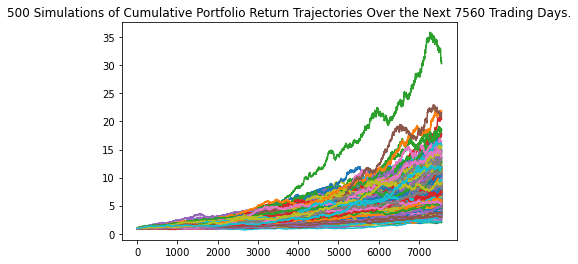

In [155]:
#Plot simulation outcomes
MC_SPY_AGG.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

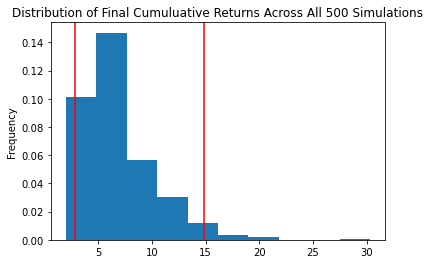

In [156]:
#Plot probability distribution and confidence intervals
MC_SPY_AGG.plot_distribution()

In [157]:
# Fetch summary statistics from the Monte Carlo simulation results
statistics = MC_SPY_AGG.summarize_cumulative_return()

# Print summary statistics
print(statistics)

count           500.000000
mean              6.880271
std               3.364982
min               1.996028
25%               4.650930
50%               6.043254
75%               8.206381
max              30.322372
95% CI Lower      2.862471
95% CI Upper     14.879601
Name: 7560, dtype: float64


In [158]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000 initial investment.
#Here we are taking our statistics at lower and upper cpi and multiplying them by a 20,000 initial investment to determine the upper and lower ranges of portfolio growth and their chance of happening.
ci_lower = round(statistics[8]*initial_investment,2)
ci_upper = round(statistics[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $57249.42 and $297592.01


In [159]:
# Set initial investment
#Here we are doing the same as previous but with a 50% boost in initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower2 = round(statistics[8]*initial_investment,2)
ci_upper2 = round(statistics[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower2} and ${ci_upper2}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $85874.13 and $446388.02


In [160]:



# 5 YEARS OPTION




In [161]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
num_sims = 500
#Here we are doing the same steps as above but for 5 year simulation
MC_5YEAR = MCSimulation(
    portfolio_data = df_five_year,
    num_simulation = num_sims,
    num_trading_days = 252 * 5,
    weights = [.40,.60]
)

In [162]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5YEAR.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/filipdjordjevic/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.004956,1.006404,1.006043,1.009720,0.994561,0.999323,1.000967,1.002873,1.012920,1.001505,...,0.995894,0.993981,0.997545,0.992143,1.004717,1.004826,0.994781,1.003177,1.006463,1.001231
2,1.000451,1.002527,1.000675,1.009418,0.997678,1.003532,1.003613,1.002313,1.011990,0.995706,...,0.987951,0.986694,0.997282,0.989351,0.996438,1.003548,0.992473,0.998979,1.019266,0.998306
3,0.999565,1.016959,1.009145,1.012301,0.999533,1.006365,1.004560,0.998080,1.012741,0.990172,...,0.990608,0.985784,1.002874,0.987640,0.991572,1.003858,0.993958,0.994704,1.014527,1.001776
4,0.992278,1.017029,1.012050,1.016193,1.001061,0.999538,1.012606,0.992891,1.009470,0.986849,...,0.985490,0.987300,1.006990,0.993495,0.986904,1.001619,0.995705,0.984983,1.019119,0.999650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.424163,1.182878,1.387841,1.775939,1.312556,2.157931,1.155507,1.054539,1.617554,1.304609,...,1.393677,1.323223,1.330948,1.518474,1.100622,1.195355,1.666831,1.085466,1.559685,1.396734
1257,1.426575,1.184282,1.384287,1.794160,1.312119,2.161186,1.147771,1.065926,1.619852,1.297836,...,1.392452,1.313624,1.341323,1.506529,1.103232,1.196940,1.669653,1.084009,1.553514,1.407675
1258,1.429581,1.185156,1.388630,1.783465,1.313034,2.150306,1.146509,1.058505,1.619077,1.304428,...,1.391453,1.300195,1.350007,1.505412,1.114983,1.186507,1.674140,1.083449,1.560033,1.396807
1259,1.439714,1.182357,1.384141,1.801681,1.311589,2.149265,1.146655,1.069916,1.617468,1.309415,...,1.389582,1.296456,1.350399,1.496306,1.103910,1.183237,1.674536,1.081221,1.560229,1.389103


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

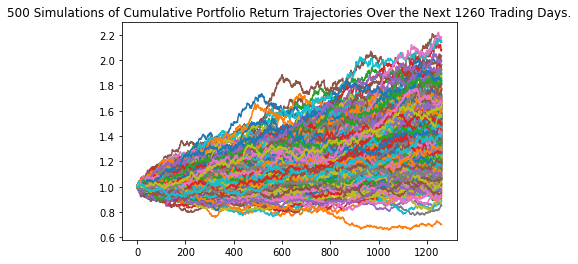

In [163]:
# Plot simulation outcomes
MC_5YEAR.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

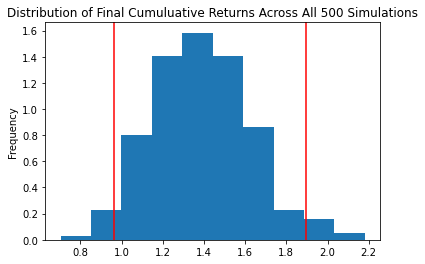

In [164]:
# Plot probability distribution and confidence intervals
MC_5YEAR.plot_distribution()

In [165]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_statistics = MC_5YEAR.summarize_cumulative_return()

# Print summary statistics
print(summary_statistics)

count           500.000000
mean              1.393134
std               0.237758
min               0.703767
25%               1.214156
50%               1.388040
75%               1.546475
max               2.181467
95% CI Lower      0.964407
95% CI Upper      1.897256
Name: 1260, dtype: float64


In [166]:
# Set initial investment

initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000

ci_lower3 = round(statistics[8]*20000,2)
ci_upper3 = round(statistics[9]*20000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower3} and ${ci_upper3}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $57249.42 and $297592.01
